In [37]:
using Distributed, SharedArrays
addprocs(32)

@everywhere using LinearAlgebra, SparseArrays, StatsBase, Distances, IterativeSolvers
@everywhere using NearestNeighbors, OptimalTransport, MultivariateStats
@everywhere using Distributed, SharedArrays
@everywhere include("util.jl")
using Plots

In [38]:

#Make a spiral with k arms and n points per arm
# PARAM: 
# arms: array of integers, n-th entry is the number of points on n-th arm
# todo: take a function f as input for sscaling along arm
function general_kSpiral(arms; st = 0.5, ed = 5)
    total_so_far = 0
    total_pts = sum(arms)
    class_num = length(arms)
    
    #Divide a full rotation into k intervals
    θ = range(0, 2π, length = class_num+1)
    
    #Make a matrix of labels
    inds = ones(Int32, total_pts) 
    
    X = zeros(total_pts, 2)
    T = zeros(total_pts)


    for i in 1:class_num

        t = ed * sqrt.(rand(arms[i])) .+ st
#         t = ed * rand(arms[i]).^2 .+ st

#         t = ed * sqrt.(LinRange(0, 1, arms[i])) .+ st
        
        sort!(t)
        
        #Plug into the parametrization for the spiral
        x = @. [cos(t) * t sin(t) * t] 

        #Rotate to give spiral effect
        X[total_so_far+1 : total_so_far + arms[i], :] = rotate(x', θ[i]) 
        T[total_so_far+1 : total_so_far + arms[i], :] = t

        #Label arm i as i
        inds[total_so_far+1 : total_so_far + arms[i]] .= i 

        total_so_far += arms[i]

    end
    
    return X, T, inds
end

general_kSpiral (generic function with 1 method)

In [39]:

# run on full scale
eps_range = exp10.(-1:0.1:1)
sgm_range = exp10.(-2:0.1:0)

# N_range = 500:500:5000
N_range = [1000]
K_range = 3:15
prop_range = [0.005, 0.01, 0.02, 0.04]
# prop_range = exp10.(range(-2, -1.2, length=4))
knn_range = 2:22

len_N_range = length(N_range)
len_prop_range = length(prop_range)
len_K_range = length(K_range)
len_eps_range = length(eps_range)
len_knn_range = length(knn_range)

σ=1.0
η=8
noise = 0.1
prop_range

4-element Vector{Float64}:
 0.005
 0.01
 0.02
 0.04

In [40]:
@everywhere function acc_along_arms(labels_all, Q, K, N_arm)
    
    soft_label, infer_label = get_labels(Q, K)        
    y = zeros(N_arm, K)
    
    for arm in 1:K
        infered_arm = infer_label[labels_all .== arm]

        for n in 1:N_arm
            y[n, arm] = sum(infered_arm[1:n] .== labels_all[labels_all .== arm][1:n]) / n
        end        
    end
    return y
end

In [41]:
@everywhere function simulate_ENT(X, N, K, labels_all, ink_idx, ink_color, ε_ent)

    ink_ind, S, P, Q_ent = make_selection_matrices(ink_idx, ink_color, N, K)
    C, μ, ν = make_ot_params(X)
#     C = pairwise(SqEuclidean(), X, X, dims=1) #Euclidean distance between nodes
#     ε_ent = 0.01
    γ_ent = sinkhorn(ones(N), ones(N), C, ε_ent)
    solve_for_likelihood!(γ_ent, Q_ent, P)

    soft_label_ent, infer_label_ent = get_labels(Q_ent, K)

    #Check what percentage of inferred labels match 
    accuracy = get_accuracy(labels_all, ink_ind, infer_label_ent, N)
    println("Solved for $N nodes, ε=$ε_ent, accuracy= ", accuracy)
    
    return Q_ent, accuracy, γ_ent
end

Solved for 2000 nodes, K= 10, ϵ= 0.1, η= 8, accuracy= 0.9309773605742684


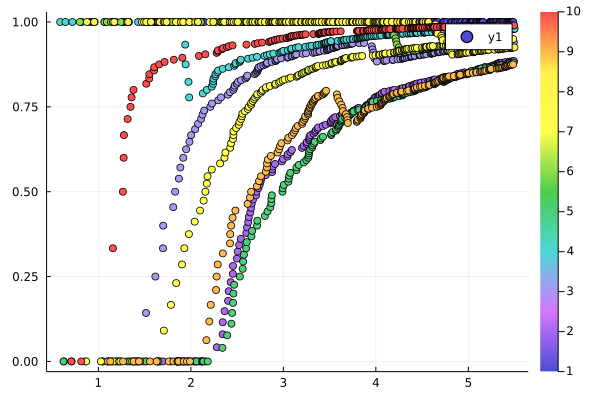

In [42]:
arms = ones(10)
N_arm = 200
arms = @. Int(floor(N_arm * arms))

X, T, labels_all = general_kSpiral(arms)
N = sum(arms)
K = length(arms)

ink_idx, ink_color = sample_labels(N, labels_all, 0.1)

Q, accuracy, γ = simulate_QOT(X, N, K, labels_all, ink_idx, ink_color,0.1, 0.1, 8)

_, infer_label = get_labels(Q, K)
Y = acc_along_arms(labels_all, Q, K, N_arm)

scatter(T, reshape(Y, :, 1), marker_z = labels_all, c = :lighttest)

In [43]:

#         arms = (sin.(range(0, step=0.1, length=K_range[i_K])) .+ 2)
arms = ones(10)
N_arm = 200
arms = @. Int(floor(N_arm * arms))

X, T, labels_all = general_kSpiral(arms)
N = sum(arms)
K = length(arms)



QOT_acc_vs_T = SharedArray{Float64}(N, len_eps_range, len_prop_range)
KNN_acc_vs_T = SharedArray{Float64}(N, len_eps_range, len_prop_range)
ENT_acc_vs_T = SharedArray{Float64}(N, len_eps_range, len_prop_range)


@sync for i_prop in 1:len_prop_range
    ink_idx, ink_color = sample_labels(N, labels_all, prop_range[i_prop])
    @distributed for param in 1:len_eps_range          

        @time Q, accuracy, γ = simulate_QOT(X, N, K, labels_all, ink_idx, ink_color, 
            eps_range[param], prop_range[i_prop], η)

#          QOT_accuracies[i_prop, param] = round(accuracy, digits=3)
        Y = acc_along_arms(labels_all, Q, K, N_arm)
        QOT_acc_vs_T[:, param, i_prop] = reshape(Y, :, 1)

        @time Q, accuracy, _ = simulate_KNN(X, N, K, labels_all, ink_idx, ink_color, 
            knn_range[param], prop_range[i_prop], σ, η)

#         KNN_accuracies[i_prop, param] = round(accuracy, digits=3)
        
        Y = acc_along_arms(labels_all, Q, K, N_arm)
        KNN_acc_vs_T[:, param, i_prop] = reshape(Y, :, 1)
        
        
        @time Q, accuracy, γ = simulate_ENT(X, N, K, labels_all, ink_idx, ink_color, eps_range[param])

#          QOT_accuracies[i_prop, param] = round(accuracy, digits=3)
        Y = acc_along_arms(labels_all, Q, K, N_arm)
        ENT_acc_vs_T[:, param, i_prop] = reshape(Y, :, 1)

        
    end
    if isdefined(Main, :IJulia)
    Main.IJulia.stdio_bytes[] = 0
    end
end



      From worker 71:	Solved for 2000 nodes, K= 10, ϵ= 0.5011872336272722, η= 8, accuracy= 0.7025252525252526
      From worker 74:	Solved for 2000 nodes, K= 10, ϵ= 0.1, η= 8, accuracy= 0.29095477386934676
      From worker 93:	Solved for 2000 nodes, K= 10, ϵ= 0.251188643150958, η= 8, accuracy= 0.9360041623309053
      From worker 71:	 71.484777 seconds (15.63 M allocations: 8.888 GiB, 3.70% gc time, 14.99% compilation time)
      From worker 73:	Solved for 2000 nodes, K= 10, ϵ= 0.5011872336272722, η= 8, accuracy= 0.9386056191467221
      From worker 79:	Solved for 2000 nodes, K= 10, ϵ= 0.12589254117941673, η= 8, accuracy= 0.5191919191919192
      From worker 76:	Solved for 2000 nodes, K= 10, ϵ= 0.1, η= 8, accuracy= 0.5724489795918367
      From worker 81:	Solved for 2000 nodes, K= 10, ϵ= 0.12589254117941673, η= 8, accuracy= 0.9042663891779397
      From worker 88:	Solved for 2000 nodes, K= 10, ϵ= 0.19952623149688797, η= 8, accuracy= 0.7943877551020408
      From worker 89:	Solved for 

┌ Warning: Sinkhorn algorithm (1000/1000): not converged
└ @ OptimalTransport ~/.julia/packages/OptimalTransport/R8czE/src/entropic/sinkhorn_solve.jl:101


      From worker 71:	Solved for 2000 nodes, K= 10, neighbours= 17, η= 8, accuracy= 0.1717171717171717 
      From worker 71:	 14.030280 seconds (33.46 k allocations: 171.012 MiB, 0.17% gc time)
      From worker 79:	Solved for 2000 nodes, K= 10, ϵ= 0.7943282347242815, η= 8, accuracy= 0.702020202020202
      From worker 79:	 63.568546 seconds (10.76 M allocations: 6.868 GiB, 1.78% gc time, 12.21% compilation time)
      From worker 71:	Solved for 2000 nodes, ε=3.1622776601683795, accuracy= 0.21919191919191916
      From worker 71:	  1.930774 seconds (572 allocations: 197.856 MiB, 0.83% gc time)
      From worker 73:	Solved for 2000 nodes, K= 10, neighbours= 17, η= 8, accuracy= 0.39438085327783556 
      From worker 73:	 10.412359 seconds (32.39 k allocations: 159.007 MiB, 0.29% gc time)
      From worker 73:	Solved for 2000 nodes, ε=3.1622776601683795, accuracy= 0.23673257023933403
      From worker 73:	  1.777025 seconds (572 allocations: 201.105 MiB, 1.26% gc time)
      From worker 

┌ Warning: Sinkhorn algorithm (1000/1000): not converged
└ @ OptimalTransport ~/.julia/packages/OptimalTransport/R8czE/src/entropic/sinkhorn_solve.jl:101


      From worker 89:	Solved for 2000 nodes, ε=1.2589254117941673, accuracy= 0.2898022892819979
      From worker 90:	172.652158 seconds (15.63 M allocations: 10.327 GiB, 2.17% gc time, 6.21% compilation time)
      From worker 89:	  2.723217 seconds (676 allocations: 205.689 MiB)
      From worker 89:	Solved for 2000 nodes, K= 10, ϵ= 7.943282347242816, η= 8, accuracy= 0.5338189386056191
      From worker 89:	 71.779329 seconds (10.37 M allocations: 4.251 GiB, 2.08% gc time, 9.54% compilation time)
      From worker 92:	172.635733 seconds (15.63 M allocations: 10.336 GiB, 2.29% gc time, 6.62% compilation time)
      From worker 74:	Solved for 2000 nodes, K= 10, ϵ= 0.6309573444801932, η= 8, accuracy= 0.6221105527638191
      From worker 74:	104.552110 seconds (10.77 M allocations: 7.695 GiB, 1.47% gc time, 7.44% compilation time)
      From worker 93:	Solved for 2000 nodes, K= 10, neighbours= 22, η= 8, accuracy= 0.2918834547346514 
      From worker 93:	  9.556744 seconds (39.63 k alloc

┌ Warning: Sinkhorn algorithm (1000/1000): not converged
└ @ OptimalTransport ~/.julia/packages/OptimalTransport/R8czE/src/entropic/sinkhorn_solve.jl:101


      From worker 79:	Solved for 2000 nodes, K= 10, neighbours= 19, η= 8, accuracy= 0.13737373737373737 
      From worker 79:	 13.329402 seconds (36.30 k allocations: 167.834 MiB)
      From worker 72:	Solved for 2000 nodes, ε=0.5011872336272722, accuracy= 0.33673469387755106
      From worker 72:	  7.787332 seconds (1.61 M allocations: 295.723 MiB, 2.54% gc time, 18.08% compilation time)
      From worker 72:	Solved for 2000 nodes, K= 10, ϵ= 3.1622776601683795, η= 8, accuracy= 0.6413265306122449
      From worker 72:	 83.614487 seconds (10.28 M allocations: 4.117 GiB, 2.15% gc time, 12.31% compilation time)
      From worker 76:	Solved for 2000 nodes, K= 10, ϵ= 0.6309573444801932, η= 8, accuracy= 0.8591836734693877
      From worker 76:	105.580221 seconds (10.77 M allocations: 7.714 GiB, 1.31% gc time, 6.91% compilation time)
      From worker 79:	Solved for 2000 nodes, ε=5.011872336272722, accuracy= 0.17323232323232318
      From worker 79:	  1.873450 seconds (508 allocations: 195.6

┌ Warning: Sinkhorn algorithm (1000/1000): not converged
└ @ OptimalTransport ~/.julia/packages/OptimalTransport/R8czE/src/entropic/sinkhorn_solve.jl:101
┌ Warning: Sinkhorn algorithm (1000/1000): not converged
└ @ OptimalTransport ~/.julia/packages/OptimalTransport/R8czE/src/entropic/sinkhorn_solve.jl:101


      From worker 77:	Solved for 2000 nodes, K= 10, ϵ= 0.6309573444801932, η= 8, accuracy= 0.9391259105098856
      From worker 77:	109.907334 seconds (10.76 M allocations: 7.719 GiB, 1.31% gc time, 7.12% compilation time)
      From worker 88:	Solved for 2000 nodes, K= 10, neighbours= 13, η= 8, accuracy= 0.5576530612244899 
      From worker 88:	 15.390287 seconds (27.97 k allocations: 202.824 MiB, 0.42% gc time)
      From worker 75:	Solved for 2000 nodes, K= 10, ϵ= 0.6309573444801932, η= 8, accuracy= 0.703030303030303
      From worker 75:	116.734451 seconds (10.77 M allocations: 7.703 GiB, 0.98% gc time, 6.23% compilation time)
      From worker 76:	Solved for 2000 nodes, K= 10, neighbours= 18, η= 8, accuracy= 0.25255102040816324 
      From worker 76:	 12.125777 seconds (34.28 k allocations: 163.063 MiB, 0.25% gc time)
      From worker 88:	Solved for 2000 nodes, ε=1.2589254117941673, accuracy= 0.27602040816326534
      From worker 88:	  2.083994 seconds (655 allocations: 202.779 

┌ Warning: Sinkhorn algorithm (1000/1000): not converged
└ @ OptimalTransport ~/.julia/packages/OptimalTransport/R8czE/src/entropic/sinkhorn_solve.jl:101


      From worker 74:	Solved for 2000 nodes, ε=3.9810717055349722, accuracy= 0.23517587939698492
      From worker 74:	  1.530980 seconds (548 allocations: 195.094 MiB)
      From worker 74:	Solved for 2000 nodes, ε=0.1, accuracy= 0.25979899497487435
      From worker 74:	 69.285395 seconds (2.29 M allocations: 1.284 GiB, 0.42% gc time, 2.25% compilation time)
      From worker 88:	Solved for 2000 nodes, K= 10, neighbours= 21, η= 8, accuracy= 0.22193877551020413 
      From worker 88:	 10.241136 seconds (38.35 k allocations: 149.855 MiB, 0.35% gc time)
      From worker 78:	Solved for 2000 nodes, K= 10, ϵ= 0.7943282347242815, η= 8, accuracy= 0.6045226130653266
      From worker 78:	132.918565 seconds (10.77 M allocations: 6.863 GiB, 0.88% gc time, 6.28% compilation time)
      From worker 88:	Solved for 2000 nodes, ε=7.943282347242816, accuracy= 0.20561224489795915
      From worker 88:	  0.992950 seconds (468 allocations: 195.352 MiB)


┌ Warning: Sinkhorn algorithm (1000/1000): not converged
└ @ OptimalTransport ~/.julia/packages/OptimalTransport/R8czE/src/entropic/sinkhorn_solve.jl:101


      From worker 80:	Solved for 2000 nodes, K= 10, neighbours= 3, η= 8, accuracy= 0.261734693877551 
      From worker 80:	 26.097955 seconds (7.70 M allocations: 465.494 MiB, 0.54% gc time, 27.83% compilation time)
      From worker 92:	Solved for 2000 nodes, ε=0.251188643150958, accuracy= 0.36530612244897964
      From worker 92:	  6.495827 seconds (1.61 M allocations: 298.199 MiB, 0.91% gc time, 11.83% compilation time)
      From worker 92:	Solved for 2000 nodes, K= 10, ϵ= 1.5848931924611136, η= 8, accuracy= 0.8551020408163266
      From worker 92:	112.804082 seconds (10.29 M allocations: 6.817 GiB, 1.83% gc time, 6.36% compilation time)
      From worker 77:	Solved for 2000 nodes, K= 10, neighbours= 10, η= 8, accuracy= 0.8855359001040582 
      From worker 77:	 17.742008 seconds (23.71 k allocations: 210.933 MiB, 0.43% gc time)
      From worker 81:	Solved for 2000 nodes, K= 10, ϵ= 0.7943282347242815, η= 8, accuracy= 0.9380853277835588
      From worker 81:	152.854480 seconds (10

┌ Warning: Sinkhorn algorithm (1000/1000): not converged
└ @ OptimalTransport ~/.julia/packages/OptimalTransport/R8czE/src/entropic/sinkhorn_solve.jl:101


      From worker 80:	Solved for 2000 nodes, K= 10, ϵ= 0.7943282347242815, η= 8, accuracy= 0.8586734693877551
      From worker 80:	102.808100 seconds (10.76 M allocations: 6.881 GiB, 1.47% gc time, 8.38% compilation time)
      From worker 75:	Solved for 2000 nodes, K= 10, neighbours= 10, η= 8, accuracy= 0.6464646464646464 
      From worker 75:	 26.409146 seconds (26.90 k allocations: 278.866 MiB, 0.30% gc time)
      From worker 81:	Solved for 2000 nodes, K= 10, neighbours= 11, η= 8, accuracy= 0.8454734651404787 
      From worker 81:	 13.399777 seconds (24.49 k allocations: 193.519 MiB, 0.45% gc time)
      From worker 92:	Solved for 2000 nodes, K= 10, neighbours= 14, η= 8, accuracy= 0.5102040816326531 
      From worker 92:	 14.875631 seconds (29.35 k allocations: 200.267 MiB)
      From worker 90:	Solved for 2000 nodes, ε=0.251188643150958, accuracy= 0.22914572864321603
      From worker 90:	  6.238163 seconds (1.61 M allocations: 291.984 MiB, 0.95% gc time, 13.26% compilation ti

      From worker 80:	Solved for 2000 nodes, K= 10, neighbours= 19, η= 8, accuracy= 0.22908163265306125 
      From worker 80:	 11.230310 seconds (35.64 k allocations: 159.022 MiB)
      From worker 78:	Solved for 2000 nodes, K= 10, neighbours= 19, η= 8, accuracy= 0.2211055276381909 
      From worker 78:	 14.726890 seconds (36.80 k allocations: 168.197 MiB)
      From worker 80:	Solved for 2000 nodes, ε=5.011872336272722, accuracy= 0.21836734693877546
      From worker 80:	  1.289799 seconds (508 allocations: 197.002 MiB)
      From worker 80:	Solved for 2000 nodes, ε=0.12589254117941673, accuracy= 0.42448979591836733
      From worker 80:	 48.279606 seconds (2.28 M allocations: 1.202 GiB, 0.48% gc time, 2.80% compilation time)
      From worker 90:	Solved for 2000 nodes, K= 10, neighbours= 22, η= 8, accuracy= 0.19447236180904526 
      From worker 90:	 13.005519 seconds (40.61 k allocations: 149.193 MiB)
      From worker 90:	Solved for 2000 nodes, ε=10.0, accuracy= 0.192462311557788

┌ Warning: Semi-smooth Newton algorithm (100/100): not converged
└ @ OptimalTransport ~/.julia/packages/OptimalTransport/R8czE/src/quadratic_newton.jl:216


      From worker 97:	Solved for 2000 nodes, K= 10, ϵ= 0.31622776601683794, η= 8, accuracy= 0.9396462018730489
      From worker 97:	1818.316559 seconds (16.16 M allocations: 164.109 GiB, 0.41% gc time, 0.63% compilation time)


┌ Warning: Semi-smooth Newton algorithm (100/100): not converged
└ @ OptimalTransport ~/.julia/packages/OptimalTransport/R8czE/src/quadratic_newton.jl:216
┌ Warning: Semi-smooth Newton algorithm (100/100): not converged
└ @ OptimalTransport ~/.julia/packages/OptimalTransport/R8czE/src/quadratic_newton.jl:216


      From worker 68:	Solved for 2000 nodes, K= 10, ϵ= 0.39810717055349726, η= 8, accuracy= 0.8285714285714285
      From worker 68:	1851.759093 seconds (16.16 M allocations: 165.753 GiB, 0.41% gc time, 0.61% compilation time)
      From worker 97:	Solved for 2000 nodes, K= 10, neighbours= 7, η= 8, accuracy= 0.9547346514047866 
      From worker 97:	 33.140732 seconds (7.71 M allocations: 684.188 MiB, 0.67% gc time, 18.56% compilation time)
      From worker 96:	Solved for 2000 nodes, K= 10, ϵ= 0.31622776601683794, η= 8, accuracy= 0.8295918367346939
      From worker 96:	1853.686765 seconds (16.16 M allocations: 164.107 GiB, 0.40% gc time, 0.60% compilation time)
      From worker 97:	Solved for 2000 nodes, ε=0.31622776601683794, accuracy= 0.47086368366285125
      From worker 97:	 11.720624 seconds (1.61 M allocations: 299.825 MiB, 0.59% gc time, 6.68% compilation time)
      From worker 97:	Solved for 2000 nodes, K= 10, ϵ= 1.9952623149688795, η= 8, accuracy= 0.8959417273673257
      

┌ Warning: Semi-smooth Newton algorithm (100/100): not converged
└ @ OptimalTransport ~/.julia/packages/OptimalTransport/R8czE/src/quadratic_newton.jl:216


      From worker 69:	Solved for 2000 nodes, K= 10, ϵ= 0.39810717055349726, η= 8, accuracy= 0.9380853277835588
      From worker 69:	1975.836114 seconds (16.16 M allocations: 165.758 GiB, 0.40% gc time, 0.57% compilation time)


┌ Warning: Semi-smooth Newton algorithm (100/100): not converged
└ @ OptimalTransport ~/.julia/packages/OptimalTransport/R8czE/src/quadratic_newton.jl:216


      From worker 69:	Solved for 2000 nodes, K= 10, neighbours= 8, η= 8, accuracy= 0.9464099895941728 
      From worker 69:	 25.747395 seconds (7.71 M allocations: 632.521 MiB, 0.48% gc time, 22.34% compilation time)
      From worker 82:	Solved for 2000 nodes, K= 10, ϵ= 0.15848931924611134, η= 8, accuracy= 0.41356783919597995
      From worker 82:	2005.713362 seconds (16.16 M allocations: 167.304 GiB, 0.41% gc time, 0.56% compilation time)
      From worker 69:	Solved for 2000 nodes, ε=0.39810717055349726, accuracy= 0.44484911550468265
      From worker 69:	  5.385978 seconds (1.61 M allocations: 298.908 MiB, 1.13% gc time, 14.59% compilation time)
      From worker 69:	Solved for 2000 nodes, K= 10, ϵ= 2.51188643150958, η= 8, accuracy= 0.8636836628511967
      From worker 69:	 42.990422 seconds (10.28 M allocations: 4.424 GiB, 2.50% gc time, 15.21% compilation time)
      From worker 69:	Solved for 2000 nodes, K= 10, neighbours= 16, η= 8, accuracy= 0.45109261186264304 
      From wor

┌ Warning: Semi-smooth Newton algorithm (100/100): not converged
└ @ OptimalTransport ~/.julia/packages/OptimalTransport/R8czE/src/quadratic_newton.jl:216


      From worker 67:	Solved for 2000 nodes, K= 10, ϵ= 0.39810717055349726, η= 8, accuracy= 0.6611111111111111
      From worker 67:	2052.643236 seconds (16.16 M allocations: 165.748 GiB, 0.35% gc time, 0.57% compilation time)
      From worker 82:	Solved for 2000 nodes, K= 10, neighbours= 4, η= 8, accuracy= 0.2668341708542713 
      From worker 82:	 54.509488 seconds (7.71 M allocations: 477.586 MiB, 0.17% gc time, 10.32% compilation time)


┌ Warning: Sinkhorn algorithm (1000/1000): not converged
└ @ OptimalTransport ~/.julia/packages/OptimalTransport/R8czE/src/entropic/sinkhorn_solve.jl:101


      From worker 82:	Solved for 2000 nodes, K= 10, ϵ= 1.0, η= 8, accuracy= 0.607537688442211
      From worker 82:	 83.974779 seconds (10.30 M allocations: 7.000 GiB, 1.25% gc time, 7.62% compilation time)


┌ Warning: Semi-smooth Newton algorithm (100/100): not converged
└ @ OptimalTransport ~/.julia/packages/OptimalTransport/R8czE/src/quadratic_newton.jl:216


      From worker 82:	Solved for 2000 nodes, K= 10, neighbours= 12, η= 8, accuracy= 0.3834170854271357 
      From worker 82:	 21.922020 seconds (28.80 k allocations: 233.348 MiB)
      From worker 82:	Solved for 2000 nodes, ε=1.0, accuracy= 0.23969849246231156
      From worker 82:	  2.435521 seconds (653 allocations: 198.305 MiB, 1.83% gc time)
      From worker 82:	Solved for 2000 nodes, K= 10, ϵ= 6.309573444801933, η= 8, accuracy= 0.2442211055276382
      From worker 82:	 93.489289 seconds (10.39 M allocations: 3.965 GiB, 0.28% gc time, 6.84% compilation time)
      From worker 67:	Solved for 2000 nodes, K= 10, neighbours= 8, η= 8, accuracy= 0.7090909090909091 
      From worker 67:	 45.339694 seconds (7.72 M allocations: 743.401 MiB, 0.38% gc time, 12.66% compilation time)
      From worker 85:	Solved for 2000 nodes, K= 10, ϵ= 0.15848931924611134, η= 8, accuracy= 0.9375650364203955
      From worker 85:	2099.360051 seconds (16.16 M allocations: 167.319 GiB, 0.35% gc time, 0.53% co

┌ Warning: Semi-smooth Newton algorithm (100/100): not converged
└ @ OptimalTransport ~/.julia/packages/OptimalTransport/R8czE/src/quadratic_newton.jl:216


      From worker 67:	Solved for 2000 nodes, ε=0.39810717055349726, accuracy= 0.29848484848484846
      From worker 67:	  4.752341 seconds (1.61 M allocations: 294.194 MiB, 1.03% gc time, 16.38% compilation time)
      From worker 67:	Solved for 2000 nodes, K= 10, ϵ= 2.51188643150958, η= 8, accuracy= 0.6
      From worker 67:	 60.544845 seconds (10.29 M allocations: 4.520 GiB, 1.37% gc time, 10.76% compilation time)
      From worker 82:	Solved for 2000 nodes, K= 10, neighbours= 20, η= 8, accuracy= 0.21155778894472366 
      From worker 82:	 14.534974 seconds (38.20 k allocations: 165.153 MiB)
      From worker 82:	Solved for 2000 nodes, ε=6.309573444801933, accuracy= 0.2015075376884422
      From worker 82:	  1.541818 seconds (485 allocations: 193.168 MiB)
      From worker 82:	Solved for 2000 nodes, ε=0.15848931924611134, accuracy= 0.24070351758793973
      From worker 82:	 48.868273 seconds (1.82 M allocations: 1.142 GiB, 0.33% gc time, 1.58% compilation time)
      From worker 67:	

┌ Warning: Semi-smooth Newton algorithm (100/100): not converged
└ @ OptimalTransport ~/.julia/packages/OptimalTransport/R8czE/src/quadratic_newton.jl:216


      From worker 85:	Solved for 2000 nodes, K= 10, neighbours= 4, η= 8, accuracy= 0.7008324661810614 
      From worker 85:	 34.663958 seconds (7.71 M allocations: 493.082 MiB, 0.20% gc time, 16.40% compilation time)


┌ Warning: Sinkhorn algorithm (1000/1000): not converged
└ @ OptimalTransport ~/.julia/packages/OptimalTransport/R8czE/src/entropic/sinkhorn_solve.jl:101


      From worker 85:	Solved for 2000 nodes, K= 10, ϵ= 1.0, η= 8, accuracy= 0.9308012486992716
      From worker 85:	 61.664212 seconds (10.29 M allocations: 7.037 GiB, 1.16% gc time, 10.61% compilation time)
      From worker 83:	Solved for 2000 nodes, K= 10, ϵ= 0.15848931924611134, η= 8, accuracy= 0.5484848484848485
      From worker 83:	2149.989723 seconds (16.16 M allocations: 167.306 GiB, 0.33% gc time, 0.51% compilation time)
      From worker 85:	Solved for 2000 nodes, K= 10, neighbours= 12, η= 8, accuracy= 0.7991675338189386 
      From worker 85:	 13.104741 seconds (25.68 k allocations: 184.064 MiB)
      From worker 85:	Solved for 2000 nodes, ε=1.0, accuracy= 0.3366285119667014
      From worker 85:	  2.189604 seconds (676 allocations: 205.689 MiB, 1.65% gc time)
      From worker 85:	Solved for 2000 nodes, K= 10, ϵ= 6.309573444801933, η= 8, accuracy= 0.5738813735691988
      From worker 85:	 64.762341 seconds (10.38 M allocations: 3.957 GiB, 0.33% gc time, 10.11% compilation

┌ Warning: Sinkhorn algorithm (1000/1000): not converged
└ @ OptimalTransport ~/.julia/packages/OptimalTransport/R8czE/src/entropic/sinkhorn_solve.jl:101


      From worker 84:	Solved for 2000 nodes, K= 10, ϵ= 1.0, η= 8, accuracy= 0.8586734693877551
      From worker 84:	 63.738835 seconds (10.29 M allocations: 7.018 GiB, 1.90% gc time, 10.91% compilation time)
      From worker 85:	Solved for 2000 nodes, K= 10, neighbours= 20, η= 8, accuracy= 0.3116545265348595 
      From worker 85:	 10.377373 seconds (36.71 k allocations: 155.338 MiB)
      From worker 85:	Solved for 2000 nodes, ε=6.309573444801933, accuracy= 0.1768990634755463
      From worker 85:	  1.124407 seconds (487 allocations: 197.438 MiB)
      From worker 85:	Solved for 2000 nodes, ε=0.15848931924611134, accuracy= 0.5676378772112383
      From worker 85:	 35.046051 seconds (1.81 M allocations: 1.105 GiB, 0.32% gc time, 2.45% compilation time)


┌ Warning: Semi-smooth Newton algorithm (100/100): not converged
└ @ OptimalTransport ~/.julia/packages/OptimalTransport/R8czE/src/quadratic_newton.jl:216


      From worker 83:	Solved for 2000 nodes, K= 10, neighbours= 4, η= 8, accuracy= 0.352020202020202 
      From worker 83:	 29.606692 seconds (7.71 M allocations: 472.401 MiB, 0.24% gc time, 18.89% compilation time)
      From worker 66:	Solved for 2000 nodes, K= 10, ϵ= 0.39810717055349726, η= 8, accuracy= 0.5301507537688442
      From worker 66:	2181.235520 seconds (16.16 M allocations: 165.745 GiB, 0.34% gc time, 0.51% compilation time)


┌ Warning: Sinkhorn algorithm (1000/1000): not converged
└ @ OptimalTransport ~/.julia/packages/OptimalTransport/R8czE/src/entropic/sinkhorn_solve.jl:101


      From worker 83:	Solved for 2000 nodes, K= 10, ϵ= 1.0, η= 8, accuracy= 0.6878787878787879
      From worker 83:	 54.036956 seconds (10.29 M allocations: 6.999 GiB, 1.22% gc time, 11.82% compilation time)
      From worker 84:	Solved for 2000 nodes, K= 10, neighbours= 12, η= 8, accuracy= 0.5984693877551021 
      From worker 84:	 18.200499 seconds (27.21 k allocations: 228.744 MiB)
      From worker 84:	Solved for 2000 nodes, ε=1.0, accuracy= 0.29438775510204085
      From worker 84:	  2.288696 seconds (676 allocations: 203.604 MiB, 1.98% gc time)
      From worker 84:	Solved for 2000 nodes, K= 10, ϵ= 6.309573444801933, η= 8, accuracy= 0.40204081632653066
      From worker 84:	 68.675517 seconds (10.38 M allocations: 3.980 GiB, 0.43% gc time, 10.12% compilation time)
      From worker 84:	Solved for 2000 nodes, K= 10, neighbours= 20, η= 8, accuracy= 0.2198979591836735 
      From worker 84:	 11.259646 seconds (37.09 k allocations: 158.136 MiB)
      From worker 84:	Solved for 2000 

┌ Warning: Semi-smooth Newton algorithm (100/100): not converged
└ @ OptimalTransport ~/.julia/packages/OptimalTransport/R8czE/src/quadratic_newton.jl:216


      From worker 95:	Solved for 2000 nodes, K= 10, ϵ= 0.31622776601683794, η= 8, accuracy= 0.6626262626262627
      From worker 95:	2219.281540 seconds (16.16 M allocations: 164.100 GiB, 0.34% gc time, 0.51% compilation time)
      From worker 83:	Solved for 2000 nodes, K= 10, neighbours= 20, η= 8, accuracy= 0.1333333333333333 
      From worker 83:	 13.048806 seconds (37.70 k allocations: 165.605 MiB)
      From worker 83:	Solved for 2000 nodes, ε=6.309573444801933, accuracy= 0.13989898989898986
      From worker 83:	  1.056544 seconds (487 allocations: 194.921 MiB)
      From worker 83:	Solved for 2000 nodes, ε=0.15848931924611134, accuracy= 0.3171717171717172
      From worker 83:	 41.957290 seconds (1.81 M allocations: 1.143 GiB, 0.29% gc time, 1.89% compilation time)
      From worker 66:	Solved for 2000 nodes, K= 10, neighbours= 8, η= 8, accuracy= 0.5909547738693468 
      From worker 66:	 55.986617 seconds (7.72 M allocations: 833.768 MiB, 0.37% gc time, 10.12% compilation time

┌ Warning: Semi-smooth Newton algorithm (100/100): not converged
└ @ OptimalTransport ~/.julia/packages/OptimalTransport/R8czE/src/quadratic_newton.jl:216


      From worker 95:	Solved for 2000 nodes, ε=0.31622776601683794, accuracy= 0.30101010101010106
      From worker 95:	  4.789652 seconds (1.61 M allocations: 294.928 MiB, 0.97% gc time, 16.15% compilation time)
      From worker 95:	Solved for 2000 nodes, K= 10, ϵ= 1.9952623149688795, η= 8, accuracy= 0.6621212121212121
      From worker 95:	 70.246318 seconds (10.29 M allocations: 4.433 GiB, 1.16% gc time, 9.11% compilation time)
      From worker 94:	Solved for 2000 nodes, K= 10, ϵ= 0.31622776601683794, η= 8, accuracy= 0.5241206030150753
      From worker 94:	2286.891156 seconds (16.16 M allocations: 164.099 GiB, 0.27% gc time, 0.49% compilation time)
      From worker 95:	Solved for 2000 nodes, K= 10, neighbours= 15, η= 8, accuracy= 0.24949494949494955 
      From worker 95:	 15.580282 seconds (31.05 k allocations: 187.460 MiB, 0.22% gc time)
      From worker 95:	Solved for 2000 nodes, ε=1.9952623149688795, accuracy= 0.24343434343434345
      From worker 95:	  1.772056 seconds (63

In [44]:
# simulate_ENT(X, N, K, labels_all, ink_idx, ink_color, 1)
Ent_acc_vs_T
# ENT_acc_vs_T

2000×21×4 SharedArray{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0

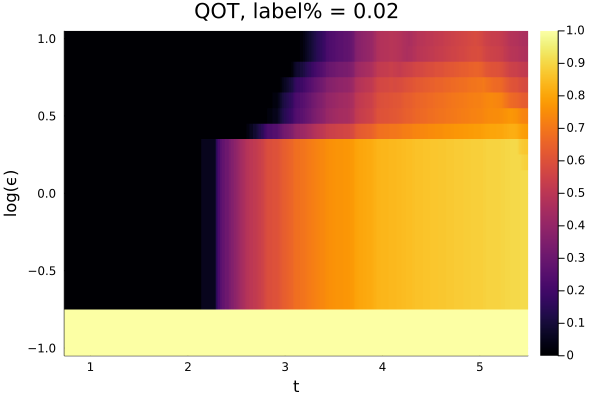

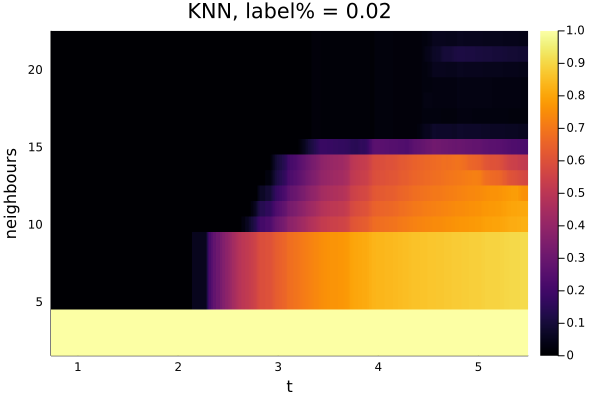

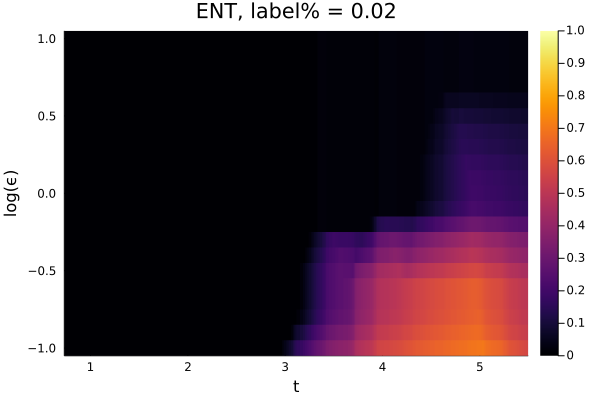

In [45]:
rmprocs(workers())

i_arm = 4
i_prop = 3

P = sortperm(T[N_arm*(i_arm-1)+1:N_arm*i_arm])

fig = heatmap(T[P], log10.(eps_range), QOT_acc_vs_T[P, :, i_prop]',  clim=(0.0, 1.0),
    ylabel= "log(ϵ)", xlabel="t", title="QOT, label% = $(prop_range[i_prop])")
display(fig)

fig = heatmap(T[P], knn_range, KNN_acc_vs_T[P, :, i_prop]',   clim=(0.0, 1.0),
    ylabel= "neighbours", xlabel="t", title="KNN, label% = $(prop_range[i_prop])")
display(fig)


fig = heatmap(T[P], log10.(eps_range), ENT_acc_vs_T[P, :, i_prop]',  clim=(0.0, 1.0),
    ylabel= "log(ϵ)", xlabel="t", title="ENT, label% = $(prop_range[i_prop])")
display(fig)

In [46]:

QOT_avg = zeros(N_arm, len_eps_range, len_prop_range)
KNN_avg = zeros(N_arm, len_eps_range, len_prop_range)

for i_arm in 1:10
    P = N_arm*(i_arm-1)+1:N_arm*i_arm
    QOT_avg .+= QOT_acc_vs_T[P, :, :]
    KNN_avg .+= KNN_acc_vs_T[P, :, :]
end
QOT_avg /= 10
KNN_avg /= 10

200×21×4 Array{Float64, 3}:
[:, :, 1] =
 0.1       0.1       0.2       0.2       …  0.1       0.1       0.1
 0.1       0.1       0.2       0.2          0.1       0.1       0.1
 0.1       0.1       0.2       0.233333     0.1       0.1       0.1
 0.1       0.1       0.2       0.25         0.1       0.1       0.1
 0.1       0.1       0.2       0.28         0.1       0.1       0.1
 0.1       0.1       0.2       0.3       …  0.1       0.1       0.1
 0.1       0.1       0.2       0.314286     0.1       0.1       0.1
 0.1       0.1       0.2       0.325        0.1       0.1       0.1
 0.1       0.1       0.2       0.333333     0.1       0.1       0.1
 0.1       0.1       0.2       0.34         0.1       0.1       0.1
 0.1       0.1       0.2       0.345455  …  0.1       0.1       0.1
 0.1       0.1       0.2       0.35         0.1       0.1       0.1
 0.1       0.107692  0.215385  0.353846     0.1       0.1       0.1
 ⋮                                       ⋱                      ⋮
 0.114815 

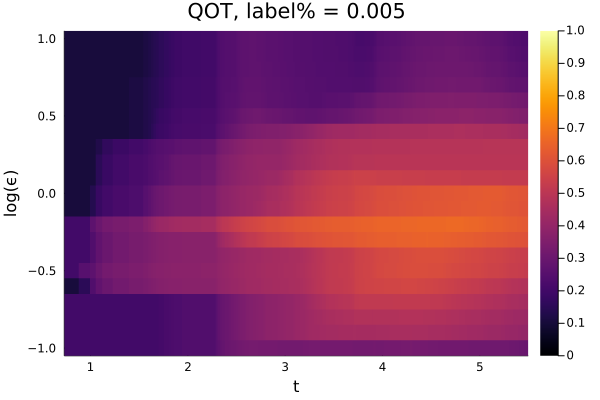

In [47]:
i_arm = 1
i_prop = 1

P = sortperm(T[1:200])

fig = heatmap(T[P], log10.(eps_range), QOT_avg[P, :, i_prop]',  clim=(0.0, 1.0), 
    ylabel= "log(ϵ)", xlabel="t", title="QOT, label% = $(prop_range[i_prop])")
display(fig)

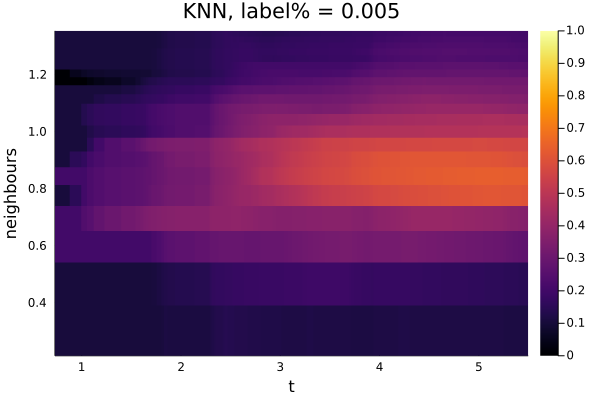

In [48]:
fig = heatmap(T[P], log10.(knn_range), KNN_avg[P, :, i_prop]',   clim=(0.0, 1.0), 
    ylabel= "neighbours", xlabel="t", title="KNN, label% = $(prop_range[i_prop])")
display(fig)

In [49]:

fig = heatmap(T[P], log10.(eps_range), ENT_avg[P, :, i_prop]',  clim=(0.0, 1.0), size=(1500, 1500),
    ylabel= "log(ϵ)", xlabel="t", title="ENT, label% = $(prop_range[i_prop])")
display(fig)

LoadError: UndefVarError: ENT_avg not defined

In [50]:
QOT = []
KNN = []
ENT = []

P = sortperm(T[1:200])


prop_range = round.(prop_range, digits=3)


for i_prop in 1: 4
    ht = heatmap(T[P], log10.(eps_range), QOT_avg[P, :, i_prop]', clim=(0.0, 1.0),size=(1500, 1500),
        ylabel= "log(ϵ)", xlabel="t", title="label = $(prop_range[i_prop])")
    push!(QOT, ht)

    ht = heatmap(T[P], log10.(knn_range), KNN_avg[P, :, i_prop]', clim=(0.0, 1.0),size=(1500, 1500),
    ylabel= "neighbours", xlabel="t", title="label = $(prop_range[i_prop])")
    push!(KNN, ht)
    
    ht = heatmap(T[P], log10.(eps_range), ENT_avg[P, :, i_prop]', clim=(0.0, 1.0),size=(1500, 1500),
        ylabel= "log(ϵ)", xlabel="t", title="label = $(prop_range[i_prop])")
    push!(ENT, ht)
end

fig = plot(QOT...)

#     savefig("../figures/t_vs_param/QOT_unf4")
display(fig)

fig = plot(KNN...)

#     savefig("../figures/t_vs_param/KNN_unf4")
display(fig)


fig = plot(ENT...)

#     savefig("../figures/t_vs_param/ENT_unf4")
display(fig)

LoadError: UndefVarError: ENT_avg not defined